In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.6 MB/s 
     |████████████████████████████████| 189 kB 44.9 MB/s 
     |████████████████████████████████| 1.2 MB 32.7 MB/s 
     |████████████████████████████████| 46 kB 3.9 MB/s 
     |████████████████████████████████| 56 kB 4.2 MB/s 
     |████████████████████████████████| 51 kB 262 kB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *
from fastai.vision.widgets import *

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', '609fc914bb8f4662899c23b7ccde4088')
results = search_images_bing(key, "adidas sports shoes")
ims = results.attrgot('contentUrl')
len(ims)

150

In [4]:
shoe_types = 'Nike', 'Adidas', 'Saucony'
path = Path('shoes')
if not path.exists():
    path.mkdir()
    for o in shoe_types:
        dest = (path/o)
        dest.mkdir(exist_ok = True)
        results = search_images_bing(key, f'{o} running shoe')
        download_images(dest, urls = results.attrgot('contentUrl'))

In [5]:
fns = get_image_files(path)
fns
failed = verify_images(fns)
failed


(#12) [Path('shoes/Adidas/00000132.jpg'),Path('shoes/Adidas/00000080.jpg'),Path('shoes/Adidas/00000141.jpg'),Path('shoes/Adidas/00000057.jpg'),Path('shoes/Adidas/00000136.jpg'),Path('shoes/Adidas/00000098.jpg'),Path('shoes/Adidas/00000095.jpg'),Path('shoes/Saucony/00000085.jpg'),Path('shoes/Saucony/00000112.jpg'),Path('shoes/Saucony/00000148.jpg')...]

In [6]:
failed.map(Path.unlink);

In [7]:
shoes = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

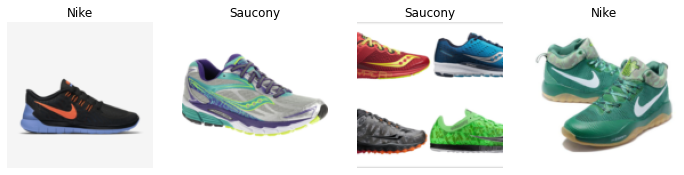

In [8]:
dls = shoes.dataloaders(path)
dls.valid.show_batch(max_n = 4, nrows = 1)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


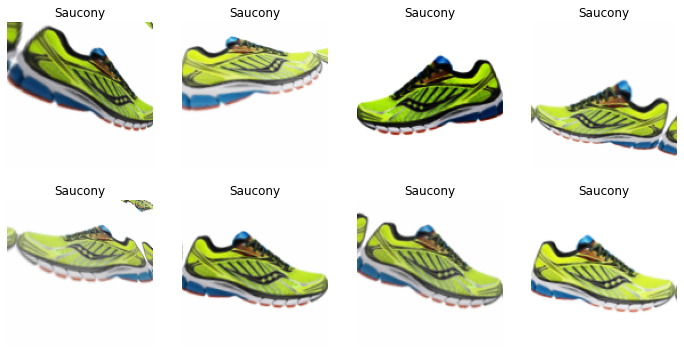

In [9]:
shoes = shoes.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = shoes.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [10]:
shoes = shoes.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = shoes.dataloaders(path)

In [15]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

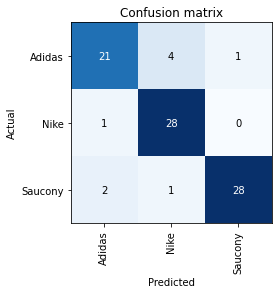

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

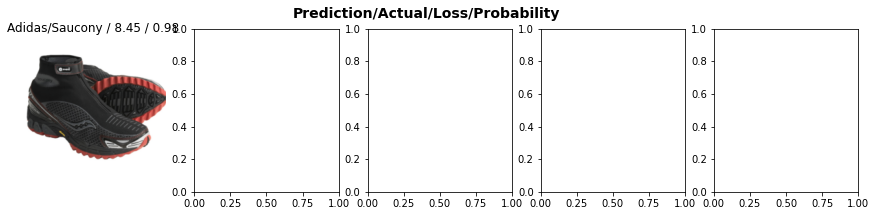

In [17]:
interp.plot_top_losses(5, nrows=1)

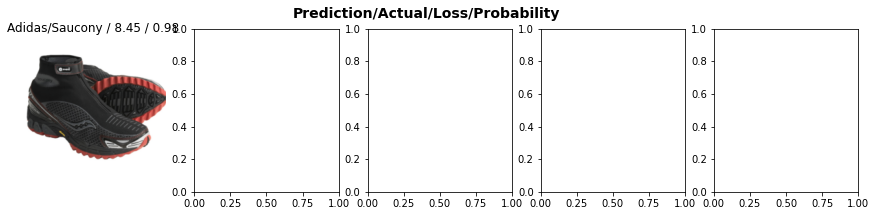

In [18]:
interp.plot_top_losses(5, nrows=1)

In [19]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [20]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')
learn_inf = load_learner(path/'export.pkl')
learn_inf.dls.vocab

['Adidas', 'Nike', 'Saucony']

In [22]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [23]:

img = PILImage.create(btn_upload.data[-1])
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl
pred,pred_idx,probs = learn_inf.predict(img)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred
btn_run = widgets.Button(description='Classify')
btn_run
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [24]:
btn_upload = widgets.FileUpload()
#hide_output
VBox([widgets.Label('Select your shoe!'), 
      btn_upload, btn_run, out_pl, lbl_pred])